Darren Colby

MSCA 32020

Homework 3

Partners: Shogo Nakano

In [134]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mdptoolbox.mdp as mdp

## Question 1: Ice Cream Problem

### Transition Probabilities
.

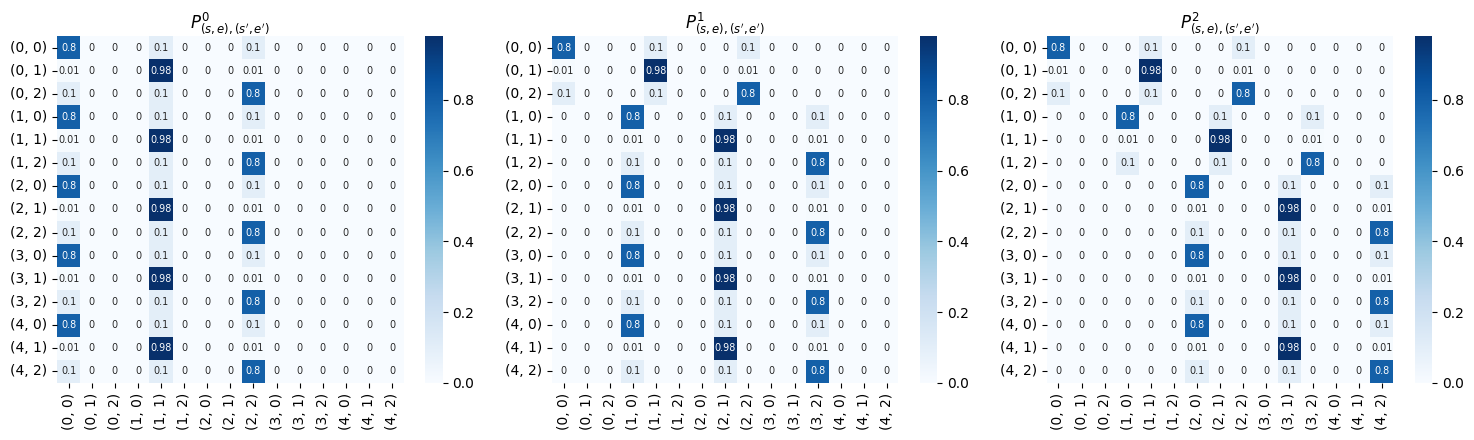

In [135]:
transition_matrix = np.zeros((3, 15, 15))
transitions_e_e_prime = np.array([[0.8, 0.1, 0.1],[0.01, 0.98, 0.01],[0.1, 0.1, 0.8]])
state_map = {0:(0,0), 1:(0,1), 2:(0,2), 3:(1,0), 4:(1,1), 5:(1,2), 6:(2,0), 7:(2,1), 
             8:(2,2), 9:(3,0), 10:(3,1), 11:(3,2), 12:(4,0), 13:(4,1), 14:(4,2)}

for (s, e, a, e_prime) in itertools.product(range(5), range(3), range(3), range(3)):
    s_prime = min(s,a) + e_prime
        
    if 0 <= s_prime <= 4:
        index_from = 3 * s + e
        index_to = 3 * s_prime + e_prime
        transition_matrix[a, index_from, index_to] = transitions_e_e_prime[e, e_prime]

# Heatmaps for each action
fig, axes = plt.subplots(1, 3, 
                         figsize=(15, 5))
for a in range(3):
    ax = axes[a]
    ax.set_title(rf"$P_{{(s,e),(s' ,e')}}^{a}$")
    ax.set_xlabel('State')
    ax.set_ylabel('Next state')
    sns.heatmap(transition_matrix[a], 
                ax=ax, 
                cmap='Blues', 
                annot=True, 
                annot_kws={'fontsize': 'x-small'}, 
                xticklabels=list(state_map.values()), 
                yticklabels=list(state_map.values()))
fig.tight_layout(rect=[0, 0.1, 1, 1])

### Rewards Matrix

In [136]:
def reward(c):
    """
    Calculate the rewards from a given consumption level

    Parameters:
        c (int): Consumption

    Returns:
        (float): the rewards for a given consumption level
    """
    return np.log(c + 1) if c >= 0 else 0

In [137]:
reward_matrix = np.zeros((3, 15, 15), dtype=np.float64)

# Update rewards for all possible values for s, e, a
for (s, e, a, e_prime) in itertools.product(range(5), range(3), range(3), range(3)):

    s_prime, c = min(s,a) + e_prime, s - min(s, a)
    r = reward(c)
                
    if 0 <= s_prime <= 4:
        index_from, index_to = 3 * s + e, 3 * s_prime + e_prime
        reward_matrix[a, index_from, index_to] = r

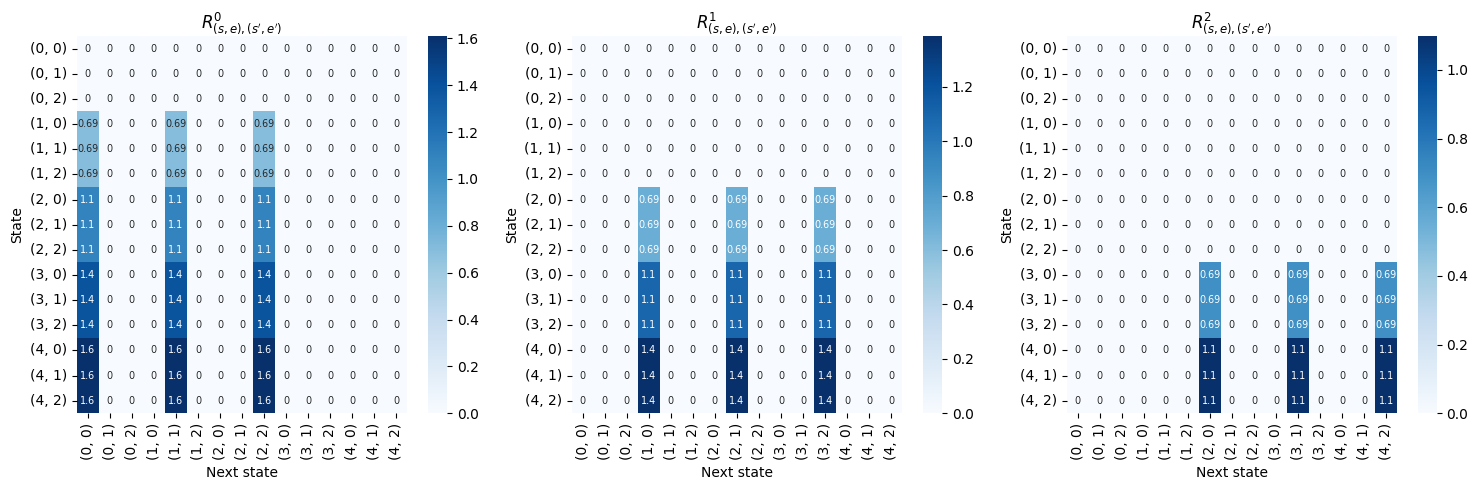

In [138]:
# Plot rewards for each action
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for a in range(3):
    ax = axes[a]
    sns.heatmap(reward_matrix[a], 
                ax=ax, 
                cmap='Blues', 
                annot=True, 
                annot_kws={'fontsize': 'x-small'}, 
                xticklabels=list(state_map.values()), 
                yticklabels=list(state_map.values()))
    ax.set_xlabel('Next state')
    ax.set_ylabel('State')
    ax.set_title(rf"$R_{{(s,e),(s' ,e')}}^{a}$")
fig.tight_layout()

### Expected Rewards

In [139]:
def expected_reward(q, num_actions, num_states, horizon, discount=0.95):
    """
    Calculate the expected reward

    Parameters:
        q (numpy.Array): array of Q-values
        num_actions (int): number of possible actions
        num_states (int): number of possible states
        horizon (int): number of tie steps
        discount (float): discount rate

    Returns:
        (float): the expected reward
    """
    state_values = np.zeros((horizon + 1, num_actions, num_states), dtype=np.float64)

    for (t, k, i) in itertools.product(range(1, horizon + 1), range(num_actions), range(num_states)):
        state_values[t, k, i] = q[k, i] + discount * np.matmul(transition_matrix[k, i, :], 
                                                               state_values[t - 1, k])
    return state_values[-1], horizon


expected_immediate_reward = np.sum(transition_matrix * reward_matrix, axis=-1).reshape(3, -1, 1)
values, horizon = expected_reward(expected_immediate_reward, 3, 15, 600)

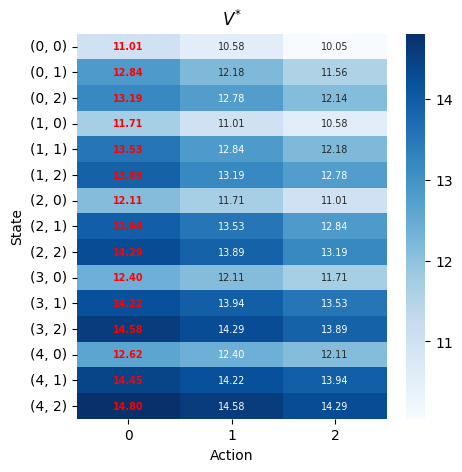

In [140]:

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_title(rf"$V^{{*}}$")
max_indices = np.argmax(values, axis=0)

heatmap = sns.heatmap(values.T, 
                      ax=ax, 
                      cmap='Blues', 
                      annot=True, 
                      annot_kws={'fontsize': 'x-small'}, 
                      fmt='.2f', 
                      yticklabels=list(state_map.values()))

# Highlight the best actions
for t, max_index in enumerate(max_indices):
    heatmap.texts[t * values.shape[0] + max_index].set_weight('bold')
    heatmap.texts[t * values.shape[0] + max_index].set_color('red')

plt.xlabel('Action')
plt.ylabel('State')
plt.show()

### Value Function Plot

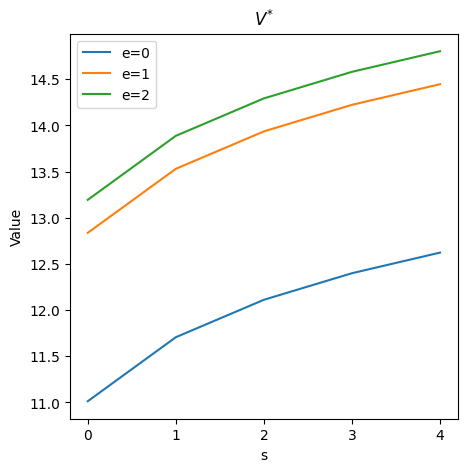

In [141]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_title(rf"$V^{{*}}$")
ax.set_xlabel('s')
ax.set_ylabel('Value')
for e in range(3):
    ax.plot(np.max(values, 
                   axis=0)[e::3], 
                   label=f'e={e}')
ax.legend()
plt.xticks(np.arange(0, 5, 1))
plt.show()

### Optimal Policy for Saving Plot

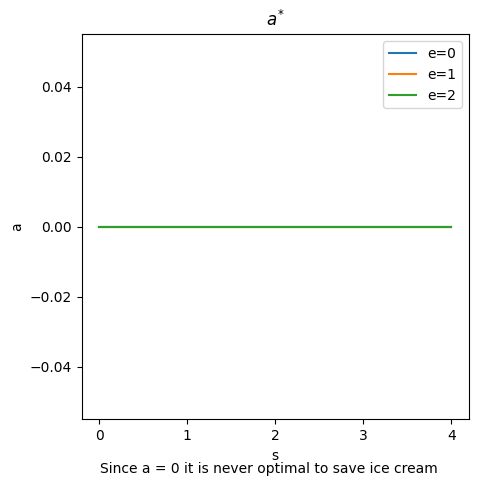

In [142]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_title(rf"$a^{{*}}$")
ax.set_xlabel('s')
ax.set_ylabel('a')
plt.figtext(0.5, 0.0025, "Since a = 0 it is never optimal to save ice cream", wrap=True, 
            horizontalalignment='center', fontsize=10)
for e in range(3):
    ax.plot(np.argmax(values, axis=0)[e::3], 
            label=f'e={e}')
ax.legend()
plt.xticks(np.arange(0, 5, 1))
plt.show()

### Optimal Policy for Consuming Plot

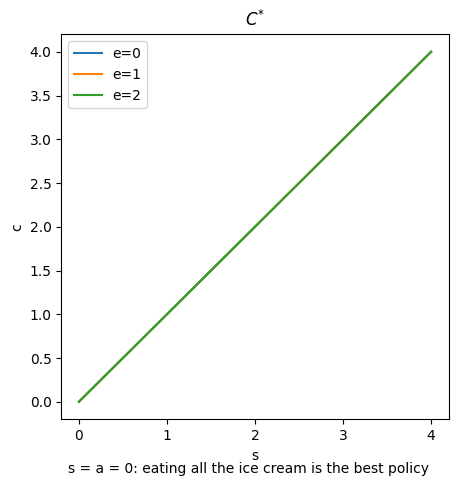

In [143]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_title(rf"$C^{{*}}$")
ax.set_xlabel('s')
ax.set_ylabel('c')
state_list = [0, 1, 2, 3, 4]
plt.figtext(0.5, 0.0025, "s = a = 0: eating all the ice cream is the best policy", wrap=True, 
            horizontalalignment='center', fontsize=10)

for e in range(3):
    action_vector = np.argmax(values, axis=0)[e::3]
    c_vector = state_list - action_vector
    ax.plot(c_vector, label=f'e={e}')
ax.legend()
plt.xticks(np.arange(0, 5, 1))
plt.show()

### Simulation

In [144]:
def simulate_se(s, e, transition_matrix, reward_matrix, iterations=1000):
    """
    Simulate the state transition of (s, e) for a given number of iterations

    Parameters:
        s (int): the initial state
        e (int): the initial e
        transtion_matrix (numpy.array): a transition matrix
        reward_matrix (numpy.array): a reward matrix
        iterations (int): the number of simulation steps

    Returns:
        df (pandas.DataFrame): the results from the simulations
    """
    idx = 3 * s + e
    optimal_policy, optimal_reward = transition_matrix[0, idx, :], reward_matrix[0, idx, :]
    time, states, actions, next_states, next_actions, rewards = [], [], [], [], [], []

    for t in range(iterations):
        next_state_idx = np.random.choice(len(optimal_policy), p=optimal_policy)
        reward = reward_matrix[0, idx, next_state_idx]
        s_prime, e_prime = next_state_idx // 3, next_state_idx % 3

        time.append(t); states.append(s); actions.append(e); next_states.append(s_prime)
        next_actions.append(e_prime); rewards.append(reward)

        optimal_policy = transition_matrix[0, next_state_idx, :]
        optimal_reward = reward_matrix[0, next_state_idx, :]

        s, e, idx = s_prime, e_prime, next_state_idx

    df = pd.DataFrame({'t': time, 's': states, 'e': actions, 's\'': next_states,
                       'e\'': next_actions,'r': rewards})
    df['beta'] = 0.95
    df['discount_reward'] = df['r'] * df['beta'] ** df['t']
    df['a'] = 0
    df['c'] = df['s'] - df['a']
    
    return df

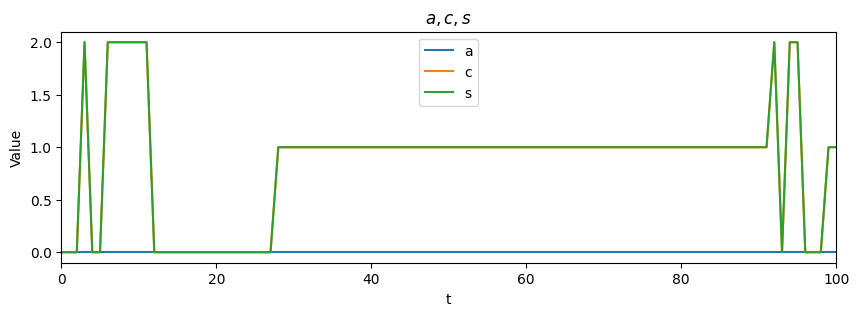

In [145]:
simulation_df = simulate_se(0, 0, transition_matrix, reward_matrix)

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.set_title(rf"$a, c, s$")
ax.set_xlabel('t')
ax.set_ylabel('Value')
ax.set_xlim(0, 100)
ax.plot(simulation_df['a'], label='a')
ax.plot(simulation_df['c'], label='c')
ax.plot(simulation_df['s'], label='s')
ax.legend()
plt.show()

### Transition and Reward Matrices with the Highest Expect Reward

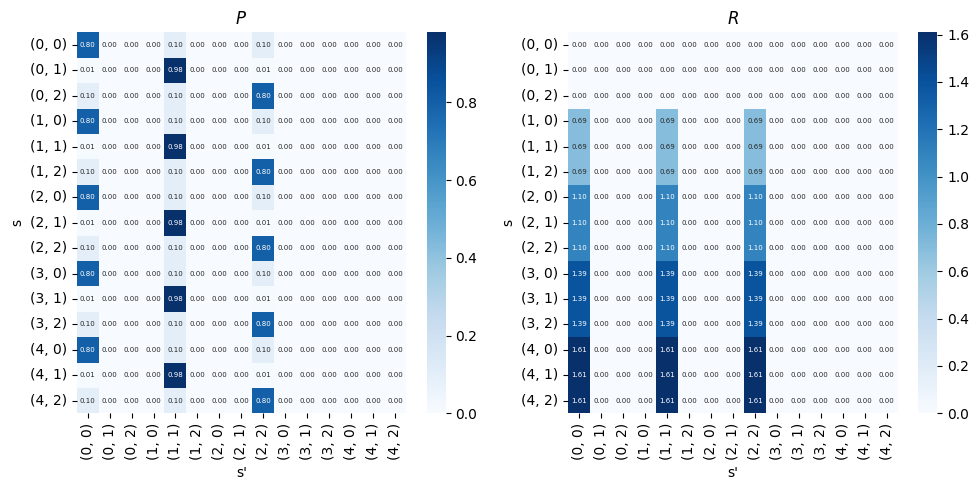

In [146]:
p_mat = transition_matrix[0, :, :]
r_mat = reward_matrix[0, :, :]

# two heatmaps for P and R
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title(rf"$P$")
ax[1].set_title(rf"$R$")
sns.heatmap(p_mat, 
            ax=ax[0], 
            cmap='Blues', 
            annot=True, 
            annot_kws={'fontsize': 5}, 
            fmt='.2f', 
            yticklabels=list(state_map.values()), 
            xticklabels=list(state_map.values()))
sns.heatmap(r_mat, 
            ax=ax[1], 
            cmap='Blues', 
            annot=True, 
            annot_kws={'fontsize': 5}, 
            fmt='.2f', 
            yticklabels=list(state_map.values()), 
            xticklabels=list(state_map.values()))
ax[0].set_xlabel('s\'')
ax[0].set_ylabel('s')
ax[1].set_xlabel('s\'')
ax[1].set_ylabel('s')
fig.tight_layout()
plt.show()

### Value Function for Markov Process with Rewards

In [147]:
T = 1000
N, M = r_mat.shape
discount = 0.95

q = np.zeros((N,1), dtype=np.float64)
v = np.zeros((N, T), dtype=np.float64)

for (i, j) in itertools.product(range(N), range(N)):
    q[i] += np.multiply(r_mat[i, j], p_mat[i, j])

for (n, i) in itertools.product(range(1, T), range(N)):
    v[i, n] = q[i] + discount * np.matmul(p_mat[i, :], v[:, n-1])

v_simulation = v[:, -1]

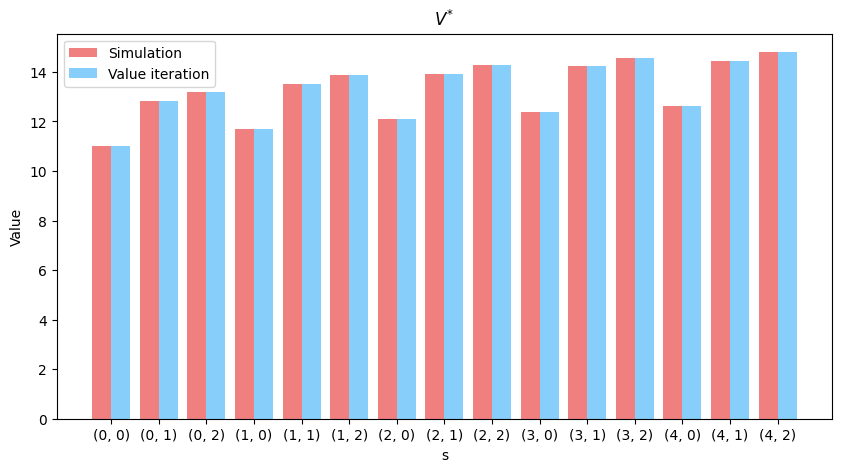

In [148]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_title(rf"$V^{{*}}$")
ax.set_xlabel('s')
ax.set_ylabel('Value')

bar_width = 0.4
positions = np.arange(0, 15, 1)

ax.bar(positions - bar_width / 2, 
       v_simulation, 
       bar_width, 
       label='Simulation', 
       color='lightcoral')
ax.bar(positions + bar_width / 2, 
       values[0], bar_width, 
       label='Value iteration', 
       color='lightskyblue')

ax.set_xticks(positions)
ax.set_xticklabels(list(state_map.values()))

ax.legend()
plt.show()

This is in line with the previous value function.

### Markov Process with Rewards Simulation

In [149]:
def multisim(s, e, iterations=1000):
    """""
    Simulate the state transition of (s, e) for 1000 periods n times

    Parameters:
        s (int): initial state
        e (int): initial e
        iterations (int): number of iterations

    Returns:
        rewards (list): a list of rewards
    """""
    rewards = []
    for i in range(iterations):
        sim_reward = simulate_se(s, e, transition_matrix, reward_matrix)['discount_reward'].sum()
        rewards.append(sim_reward)

    return rewards

In [150]:
results = {}

for idx in range(15):
    s, e = idx // 3, idx % 3
    temp = multisim(s, e)
    results[idx] = temp

results = pd.DataFrame(results)
average_reward = results.mean(axis=0)

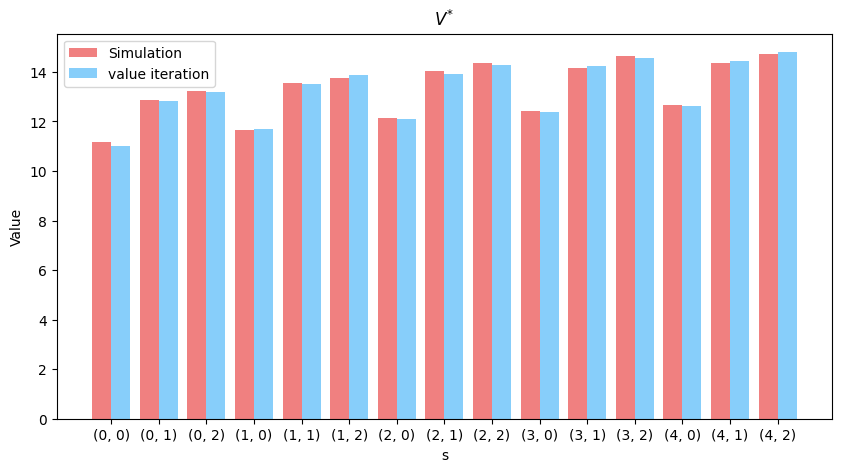

In [151]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_title(rf"$V^{{*}}$")
ax.set_xlabel('s')
ax.set_ylabel('Value')

bar_width = 0.4  
positions = np.arange(0, 15, 1)
ax.bar(positions - bar_width / 2, 
       average_reward, 
       bar_width, 
       label='Simulation', 
       color='lightcoral')
ax.bar(positions + bar_width / 2, 
       values[0], 
       bar_width, 
       label='value iteration', 
       color='lightskyblue')

ax.set_xticks(positions)
ax.set_xticklabels(list(state_map.values()))
ax.legend()
plt.show()

This is in line with the previous value function.

### Policy Iteration

In [152]:
P = transition_matrix.copy()
rr = reward_matrix.copy()
K, N, M = P.shape

# Expected reward for each state
q = np.zeros((K, N, 1),dtype=np.float64)

for (i, k, j) in itertools.product(range(N), range(K), range(M)):
    q[k, i, 0] = q[k, i, 0] + rr[k, i, j] * P[k, i, j]

T = 100

# Instantiate vectors  and auxilary variables to store value function and decisions
v = np.zeros((N, T), dtype=np.float64)
d = np.ones((N, T), dtype=int)
pp = np.zeros((N, N), dtype=np.float64)
qvec = np.zeros((N, 1), dtype=np.float64)

for (n, i) in itertools.product(range(1, T), range(N)):
        
        # Policy improvement
        rhs = np.zeros((1,K),dtype=np.float64)

        for k in range(0, K):
            rhs[0][k] = q[k][i][0] + np.matmul(P[k, i, :], v[:, n - 1]) 
        v[i, n] = max(rhs[0])
        d[i, n] = np.argmax(rhs[0])

        # Value determination
        for i in range(0,N):
            pp[i, :] = P[d[i, n], i, :]
    
        A = np.concatenate((np.identity(N) - pp, np.ones((N, 1))), axis=1)
        A = np.delete(A, N - 1, 1)
    
        for i in range(0, N):
            qvec[i, 0] = q[d[i, n], i, 0]

        tmp = np.matmul(np.linalg.inv(A), qvec)
        g = tmp[N - 1]
        tmp[N - 1] = 0
        v[:, n] = tmp.T

v = v.T
d = d.T

d[-1, :]

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2])

## Question 2: Mobile Robot Problem

### Transition Matrices

In [153]:
t_right, t_left = np.zeros((21,21)), np.zeros((21, 21)) # Transition matrices

for i in range(1, 20):
    t_right[i, i - 1], t_right[i, i + 1] = 0.2, 0.8

t_right[0, 0], t_right[20, 20] = 1, 1

for i in range(1, 20):
    t_left[i, i - 1], t_left[i, i + 1] = 0.8, 0.2

t_left[0, 0], t_left[20, 20] = 1, 1

transition_matrix = np.zeros((2, 21, 21))
transition_matrix[0], transition_matrix[1] = t_left, t_right

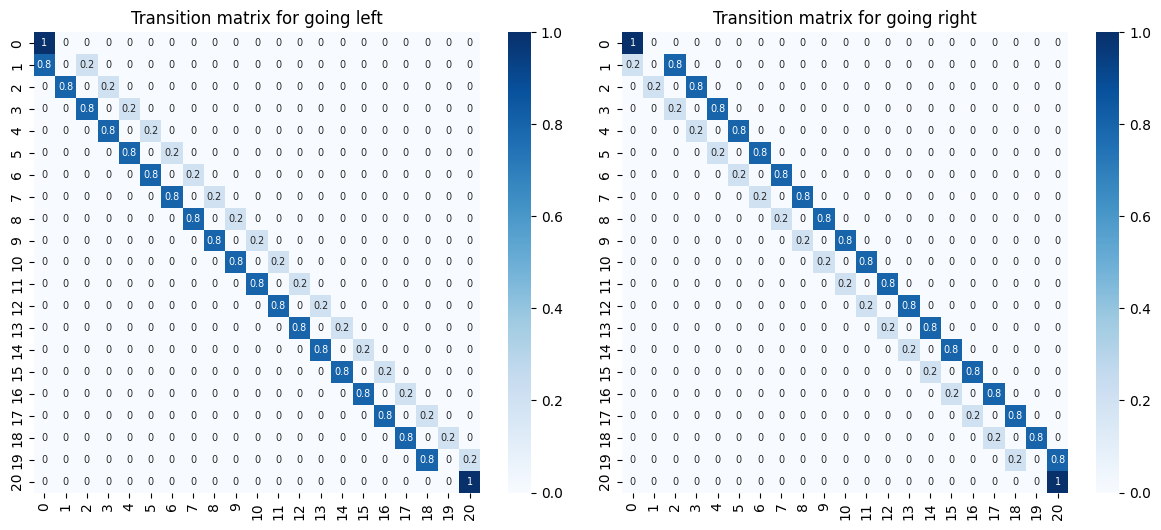

In [154]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].set_title('Transition matrix for going left')
ax[1].set_title('Transition matrix for going right')
sns.heatmap(transition_matrix[0], 
            ax=ax[0], 
            cmap='Blues', 
            annot=True, 
            annot_kws={'fontsize': 'x-small'})
sns.heatmap(transition_matrix[1], 
            ax=ax[1], 
            cmap='Blues', 
            annot=True, 
            annot_kws={'fontsize': 'x-small'})
fig.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()

### Rewards Matrices

In [155]:
right_rewards = np.zeros((21, 21))

for i in range(1, 20):
    right_rewards[i, i - 1], right_rewards[i, i + 1] = 0.05, 0.05

right_rewards[0, 0], right_rewards[20, 20] = 0, 0
right_rewards[19, 20], right_rewards[1,0] = 1, -1

left_rewards = right_rewards.copy()

rewards_matrix = np.zeros((2, 21, 21))
rewards_matrix[0] = left_rewards
rewards_matrix[1] = right_rewards

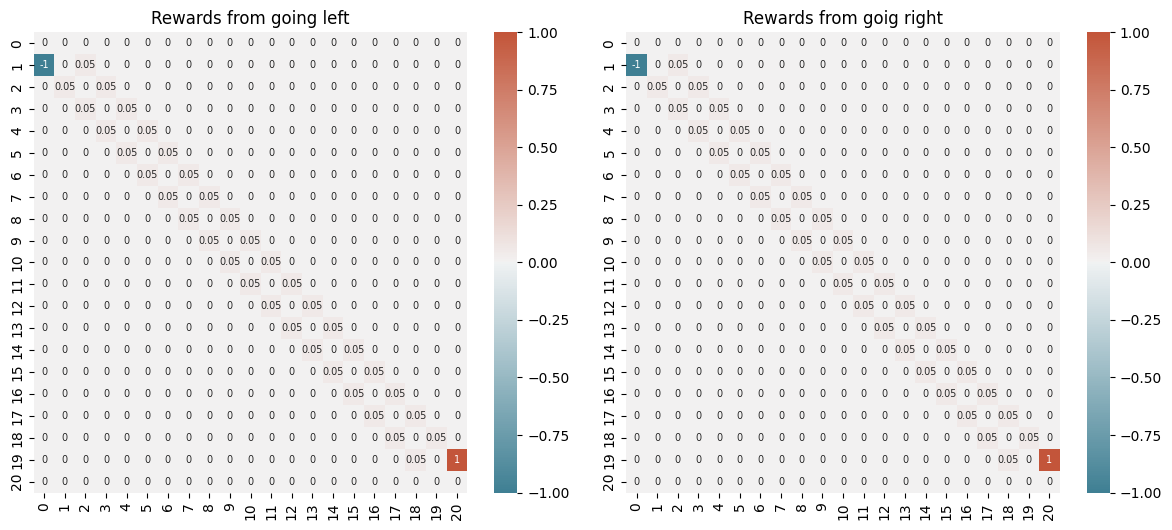

In [156]:
palette = sns.diverging_palette(220, 20, as_cmap=True)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].set_title('Rewards from going left')
ax[1].set_title('Rewards from goig right')
sns.heatmap(rewards_matrix[0], 
            ax=ax[0], 
            cmap=palette, 
            annot=True, 
            annot_kws={'fontsize': 'x-small'})
sns.heatmap(rewards_matrix[1], ax=ax[1], 
            cmap=palette, 
            annot=True, 
            annot_kws={'fontsize': 'x-small'})
fig.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()

### Conditional Immediate Expected Reward

In [157]:
n_states, n_actions = 21, 2
q = np.zeros((n_actions, n_states), dtype=np.float64)

for action in range(n_actions):
    q[action] = np.sum(transition_matrix[action] * rewards_matrix[action], axis=1).reshape(n_states)

In [158]:
def get_expected_reward(q, horizon, n_states=21, n_actions=2):
    """
    Estimate the expected rewards of an MDP

    Parameters:
        q (numpy.array): Q-values
        horizon (int): the number of periods in which the MDP ocurrs
        n_states (int): the number of states
        n_actions (int): the number of actions

    Returns:
        (tuple(float, int)): the expected conditional immediate reward and number of periods
    """
    v = np.zeros((horizon + 1, n_actions, n_states), dtype=np.float64)
    
    for time in range(1, horizon + 1):
        for action in range(n_actions):
            for state in range(n_states):
                v[time, action, state] = q[action, state] + np.matmul(transition_matrix[action, state, :], 
                                                                      v[time - 1, action])
    # get last state
    return v[-1], horizon


immediate_reward, h = get_expected_reward(q, 1)

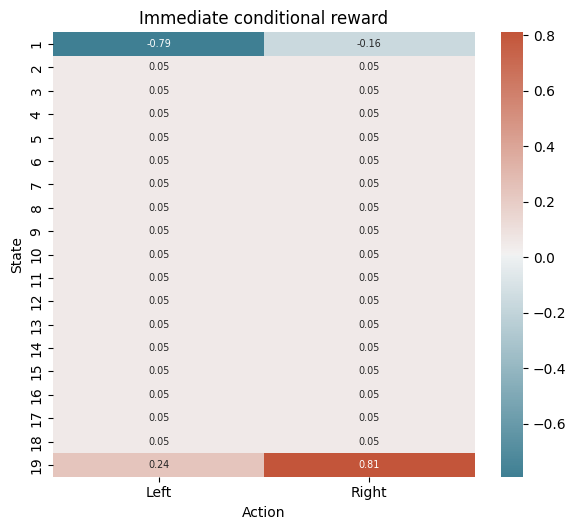

In [159]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_title('Immediate conditional reward')
sns.heatmap(immediate_reward.T[1:20, :], 
            ax=ax, 
            cmap=palette, 
            annot=True, 
            annot_kws={'fontsize': 'x-small'})
ax.set_xlabel('Action')
ax.set_ylabel("State")
ax.set_xticklabels(["Left", "Right"])
ax.set_yticklabels(np.arange(1, 20))
fig.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()

### Matrix Inversion Technique

In [160]:
P_policy, q_policy = transition_matrix[1], immediate_reward[1]

right_state_value = np.squeeze(np.matmul(np.linalg.inv(np.eye(n_states - 2) - P_policy[1:-1, 1:-1]),
            q_policy[1:-1, np.newaxis]))

P_policy = transition_matrix[0]
q_policy = immediate_reward[0]

left_state_value = np.squeeze(np.matmul(np.linalg.inv(np.eye(n_states - 2) - P_policy[1:-1, 1:-1]),
        q_policy[1:-1, np.newaxis]))

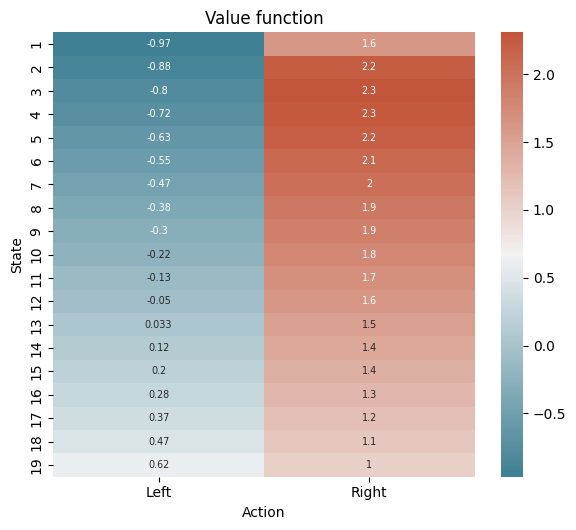

In [161]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_title('Value function')
sns.heatmap(np.vstack((left_state_value, right_state_value)).T[0:20,:], 
            ax=ax, cmap=palette, 
            annot=True, 
            annot_kws={'fontsize': 'x-small'})
ax.set_xlabel('Action')
ax.set_ylabel("State")
ax.set_xticklabels(["Left", "Right"])
ax.set_yticklabels(np.arange(1, 20))
fig.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()

### Policy Evaluation

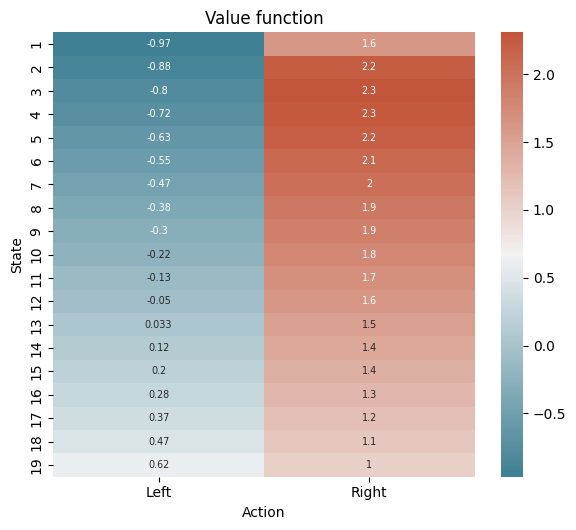

In [162]:
reward, hz = get_expected_reward(q, 100)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_title('Value function')
sns.heatmap(reward.T[1:20, :], 
            ax=ax, 
            cmap=palette, 
            annot=True, 
            annot_kws={'fontsize': 'x-small'})
ax.set_xlabel('Action')
ax.set_ylabel("State")
ax.set_xticklabels(["Left", "Right"])
ax.set_yticklabels(np.arange(1, 20))
fig.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()

### Optimal Policy and Value Function

In [169]:
def get_optimal_policy(q, horizon=600, n_actions=2, n_states=21):
    """
    Find the optimal policy in an MDP

    Parameters:
        q (numpy.array): Q-values
        horizon (int): the time horizon
        n_actions (int): the number of possible actions
        n_states (int): the number of possible states

    Returns:
        tuple(numpy.array, numpy.array, numpy.array): values, policies, horizons
    """
    v = np.zeros((horizon + 1, n_actions, n_states), dtype=np.float64)
    value = np.zeros((horizon + 1 , n_states), dtype=np.float64)
    policies = np.zeros((horizon + 1, n_states), dtype=np.int32)

    for (time, action, state) in itertools.product(range(1, horizon + 1), range(n_actions), range(n_states)):
        v[time, action, state] = q[action, state] + np.matmul(transition_matrix[action, state, :], v[time - 1, action]) * 0.95

        value[time] = np.max(v[time], axis=0)
        policies[time] = np.argmax(v[time], axis=0)

    return value, policies, horizon


values, policies, hor = get_optimal_policy(q)
print("The optimal policy is:")
print(policies[-1])
print("Always going right")

The optimal policy is:
[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
Always going right


In [170]:
print("The values of the states in the optimal policy are:")
print(values[-1])

The values of the states in the optimal policy are:
[0.         0.51512891 0.88832751 0.97428029 0.9940764  0.99863571
 0.99968579 0.99992763 0.99998333 0.99999616 0.99999912 0.9999998
 0.99999995 0.99999999 1.         1.         1.         1.
 1.         1.         0.        ]


### Optimal Policy and Value Using PyMDPToolbox

In [171]:
fh = mdp.FiniteHorizon(transition_matrix, rewards_matrix, 0.95, 100)
fh.run()

V = fh.V
fh_policy = fh.policy

print("The optimal policy is:")
print(fh_policy[1:20, 0])
print("Always going right")

The optimal policy is:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Always going right


In [172]:
print("The values of the states in the optimal policy are:")
print(V[1:20, 0])

The values of the states in the optimal policy are:
[0.51512891 0.88832751 0.97428029 0.9940764  0.99863571 0.99968579
 0.99992763 0.99998333 0.99999616 0.99999912 0.9999998  0.99999995
 0.99999999 1.         1.         1.         1.         1.
 1.        ]


### Value Iteration with PyMDPTools

In [173]:
vi = mdp.ValueIteration(transition_matrix, rewards_matrix, 0.95)
vi.run()
print("The optimal policy is:")
print(vi.policy)
print("Always going right")

The optimal policy is:
(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0)
Always going right


In [174]:
print("The values of the states in the optimal policy are:")
print(vi.V)
print("This is the same as the previous question")

The values of the states in the optimal policy are:
(0.0, 0.5142604684494146, 0.8872419614358821, 0.9735979743156928, 0.9934948914433575, 0.9983301259806413, 0.9994491789284055, 0.9998132359813308, 0.9998994892208457, 0.9999582075158883, 0.9999726345474511, 0.9999885626072936, 0.9999925312270338, 0.9999970590756166, 0.9999981903273643, 0.9999993477184221, 0.99999963702854, 0.9999998868358684, 0.9999999492857243, 0.9999999898572115, 0.0)
This is the same as the previous question


### Optimal Policy

Always going right is the optimal policy because that is what value iteration and policy evaluation converged to and they are both garaunteed to converge to an optimal policy.